# STM Transit Delay Data Preprocessing

## Overview

This notebook preprocesses data about STM trip updates weather and traffic, data in order to build a regression and classification model that predicts delays in seconds.

## Data Description

`trip_id`: Unique identifier for the transit trip.<br>
`exp_trip_duration`: Expected duration of a trip, in seconds.<br>
`route_id`: Unique identifier for a bus or metro line.<br>
`route_direction`: Direction of the trip (Nord, South, West, East).<br>
`route_type`: Type of bus line (e.g. Night).<br>
`stop_id`: Unique identifier of a stop.<br>
`stop_name`: Name of the stop.<br>
`stop_lat`, `stop_lon`: Stop coordinates.<br>
`stop_distance`: Distance between the previous and current stop, in meters.<br>
`stop_sequence`: Sequence of the stop, for ordering.<br>
`trip_progress`: How far along the trip is the vehicle, from 0 (first stop) to 1 (last stop).<br>
`schedule_relationship`: State of the schedule: "scheduled", "skipped" or "no data".
`wheelchair_boarding`: Indicates if the stop is accessible for people in wheelchair.<br>
`rt_arrival_time`, `rt_departure_time`, `sch_arrival_time`, `sch_departure_time`: Realtime and scheduled times, in UTC.<br>
`delay`: Difference between real and scheduled arrival time, in seconds.<br>
`exp_delay_prev_stop`: Expected duration between the previous and current stop, in seconds.<br>
`temperature`: Air temperature at 2 meters above ground, in Celsius.<br>
`relative_humidity`: Relative humidity at 2 meters above ground, in percentage.<br>
`dew_point`: Dew point temperature at 2 meters above ground, in Celsius.<br>
`precipitation`: Total precipitation (rain, showers, snow) sum of the preceding hour, in millimeters.<br>
`pressure`: Atmospheric air pressure reduced to mean sea level (msl), in hPa.<br>
`cloud_cover`: Total cloud cover as an area fraction.<br>
`windspeed`: Wind speed at 10 meters above ground, in kilometers per hour.<br>
`wind_direction`: Wind direction at 10 meters above ground.<br>
`wind_gusts`: Gusts at 10 meters above ground as a maximum of the preceding hour.<br>

## Imports

In [1]:
from kneed import KneeLocator
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import sys

In [ ]:
# Import custom code
sys.path.insert(0, '..')
from scripts.custom_functions import LOCAL_TIMEZONE

In [3]:
# Load data
df = pd.read_parquet('../data/stm_weather_merged.parquet')
stops_df = pd.read_csv('../data/download/stops_2025-04-30.txt', usecols=['stop_code', 'stop_name', 'stop_lat', 'stop_lon']) \
	.rename(columns={'stop_code': 'stop_id'})

## Data Preprocessing

### Get historical average delay

Since the volume of data is so large, a big portion of it can be used as "historical data" to calculate the average delay. The rest will be used for preprocessing and modeling.

In [4]:
# Convert scheduled arrival time to local timezone
df['sch_arrival_time'] = df['sch_arrival_time'].dt.tz_convert(LOCAL_TIMEZONE)

In [5]:
# Sort data by arrival time
df = df.sort_values(by='sch_arrival_time')

In [6]:
# Get day of week and hour
df['day'] = df['sch_arrival_time'].dt.day_of_week
df['hour'] = df['sch_arrival_time'].dt.hour

In [ ]:
# Separate data
train_size = int(1e6)
total_rows = len(df)
index = total_rows - train_size

past_df = df.iloc[:index].copy().reset_index(drop=True)
new_df = df.iloc[index:].copy().reset_index(drop=True)

In [8]:
# Calculate average delay by stop and hour
avg_delay_df = past_df.groupby(['stop_id', 'hour'])['delay'].mean().reset_index()
avg_delay_df = avg_delay_df.rename(columns={'delay': 'hist_avg_delay'})

In [9]:
# Merge new data with average
df = pd.merge(left=new_df, right=avg_delay_df, how='left', on=['stop_id', 'hour'])

In [10]:
print(df['hist_avg_delay'].isna().sum())

8


In [11]:
# Fill missing values with overall delay
df['hist_avg_delay'] = df['hist_avg_delay'].fillna(df['delay'].mean())

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800000 entries, 0 to 799999
Data columns (total 33 columns):
 #   Column                 Non-Null Count   Dtype                         
---  ------                 --------------   -----                         
 0   trip_id                800000 non-null  int64                         
 1   exp_trip_duration      800000 non-null  float64                       
 2   route_id               800000 non-null  int64                         
 3   route_direction        800000 non-null  object                        
 4   route_type             800000 non-null  object                        
 5   stop_id                800000 non-null  int64                         
 6   stop_name              800000 non-null  object                        
 7   stop_lat               800000 non-null  float64                       
 8   stop_lon               800000 non-null  float64                       
 9   stop_distance          800000 non-null  float64 

### Encode Datetime

In [13]:
# Convert hour to time of day
def time_of_day(hour):
  if 0 <= hour < 6:
    return 'night'
  elif 6 <= hour < 12:
    return 'morning'
  elif 12 <= hour < 18:
    return 'afternoon'
  else:
    return 'evening'

df['time_of_day'] = df['hour'].apply(time_of_day)
df['time_of_day'].value_counts()

time_of_day
afternoon    257604
morning      239704
evening      235991
night         66701
Name: count, dtype: int64

In [14]:
# Use One Hot Encoding
one_hot = pd.get_dummies(df['time_of_day'], drop_first=True, dtype='int64', prefix='time_of_day')
df = df.join(one_hot).drop('time_of_day', axis=1)

In [15]:
# Add boolean value is_peak_hour (weekdays from 7-9am or 4-6pm)
df['is_peak_hour'] = (df['hour'].isin([7, 8, 9, 16, 17, 18])).astype('int64')

In [16]:
# Drop unneeded time-related columns
df = df.drop(['rt_arrival_time', 'rt_departure_time', 'sch_arrival_time', 'sch_departure_time', 'hour', 'day'], axis=1)

### Use One Hot Encoding for route_type, schedule_relationship, trip_progress and route_direction

In [18]:
df['route_type'].value_counts()

route_type
Day                         461180
Rush Hour High Frequency    200236
All Day High Frequency      116523
Night                        22061
Name: count, dtype: int64

In [19]:
# Collapse categories
df['route_type'] = np.where(df['route_type'].str.contains('High Frequency'), 'HighFrequency', df['route_type'])
df['route_type'].value_counts()

route_type
Day              461180
HighFrequency    316759
Night             22061
Name: count, dtype: int64

In [20]:
# Use One Hot Encoding
one_hot = pd.get_dummies(df['route_type'], drop_first=True, dtype='int64', prefix='route_type')
df = df.join(one_hot).drop('route_type', axis=1)

In [21]:
df['schedule_relationship'].value_counts()

schedule_relationship
Scheduled    778777
Skipped       19586
NoData         1637
Name: count, dtype: int64

In [22]:
# Collapse categories
df['schedule_relationship'] = np.where(df['schedule_relationship'] != 'Scheduled', 'NotScheduled', df['schedule_relationship'])
df['schedule_relationship'].value_counts()

schedule_relationship
Scheduled       778777
NotScheduled     21223
Name: count, dtype: int64

In [23]:
# Use One Hot Encoding
one_hot = pd.get_dummies(df['schedule_relationship'], drop_first=True, dtype='int64', prefix='sch_rel')
df = df.join(one_hot).drop('schedule_relationship', axis=1)

In [24]:
# Create buckets for trip_progress
ranges = [0, 0.5, 1.0]
labels = ['first_half', 'second_half']

df['trip_phase'] = pd.cut(df['trip_progress'], bins=ranges, labels=labels, include_lowest=True, right=False)
df['trip_phase'].value_counts(normalize=True)

trip_phase
second_half    0.553553
first_half     0.446447
Name: proportion, dtype: float64

In [25]:
# Use One Hot Encoding
one_hot = pd.get_dummies(df['trip_phase'], drop_first=True, dtype='int64', prefix='trip_phase')
df = df.join(one_hot).drop(['trip_progress', 'trip_phase'], axis=1)

In [26]:
df['route_direction'].value_counts()

route_direction
West     282659
East     278773
North    123119
South    115449
Name: count, dtype: int64

In [27]:
# Use One Hot Encoding
one_hot = pd.get_dummies(df['route_direction'], drop_first=True, dtype='int64', prefix='route_direction')
df = df.join(one_hot).drop('route_direction', axis=1)

### Use K-Means to cluster stop coordinates

In [28]:
# Scale coordinates
coords_df = stops_df[['stop_lat', 'stop_lon']]
scaler_coords = StandardScaler()
coords_df_scaled = scaler_coords.fit_transform(coords_df)
coords_df_scaled = pd.DataFrame(coords_df_scaled, columns=scaler_coords.get_feature_names_out())
coords_df_scaled

,stop_lat,stop_lon
0,-1.224117,0.392250
1,-1.224117,0.392250
2,-1.226468,0.384756
3,-1.149054,0.495472
4,-1.149054,0.495472
...,...,...
8989,-1.434924,-2.783942
8990,-1.785955,-3.225377
8991,-1.907444,-3.130798
8992,1.397607,-0.224108


In [29]:
# Build multiple K-Means models
models = []
for k in range(2, 31):
	kmeans = KMeans(n_clusters=k, random_state=42, init='k-means++')
	kmeans.fit(coords_df_scaled)
	labels = kmeans.labels_
	models.append({
		'k': k,
		'ssd': kmeans.inertia_,
		'silhouette': silhouette_score(coords_df_scaled, labels, metric='euclidean', random_state=42),
	})

models_df = pd.DataFrame(models).set_index('k')

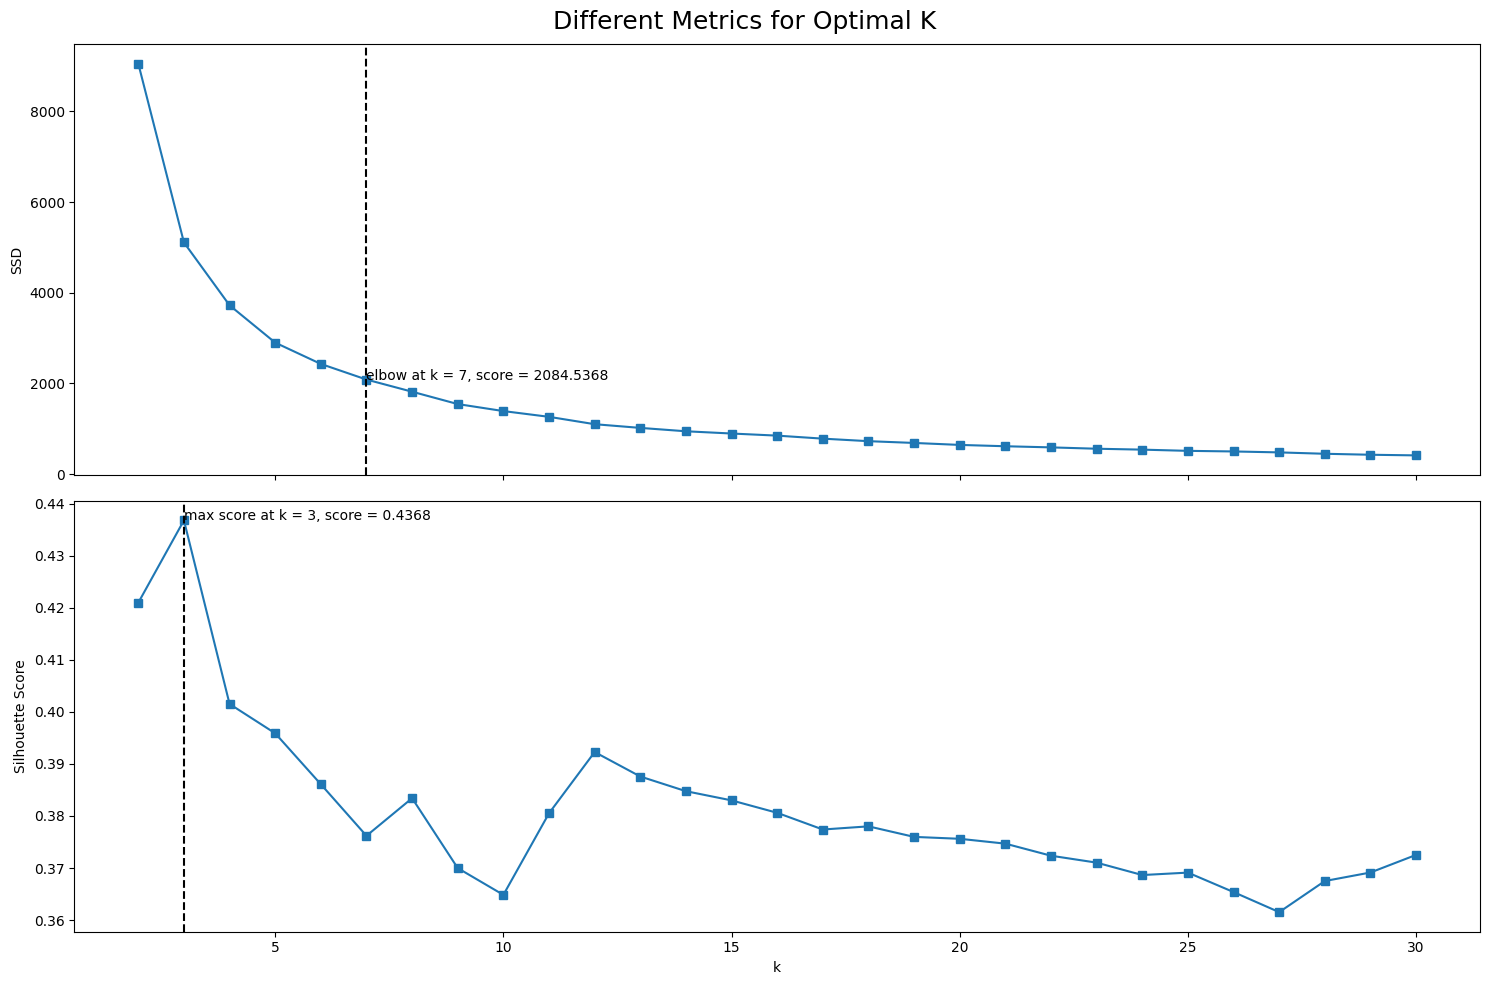

In [30]:
# Display K plots
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(15,10), sharex=True)

# Elbow Method
kneedle = KneeLocator(models_df.index, models_df['ssd'], curve='convex', direction='decreasing')
optimal_k = kneedle.elbow
optimal_score = models_df.loc[optimal_k, 'ssd']
ax1.plot(models_df['ssd'], marker='s')
ax1.set_ylabel('SSD')
ax1.axvline(x=optimal_k, color='black', linestyle='--')
ax1.annotate(f'elbow at k = {optimal_k}, score = {round(optimal_score, 4)}', xy=(optimal_k, optimal_score))

# Silhouette Score
optimal_k = models_df['silhouette'].idxmax()
max_score = models_df['silhouette'].max()
ax2.plot(models_df['silhouette'], marker='s')
ax2.set_xlabel('k')
ax2.set_ylabel('Silhouette Score')
ax2.axvline(x=optimal_k, color='black', linestyle='--')
ax2.annotate(f'max score at k = {optimal_k}, score = {round(max_score, 4)}', xy=(optimal_k, max_score))

fig.suptitle(f'Different Metrics for Optimal K', fontsize=18)
fig.tight_layout()
fig.savefig('../images/k_means_plots.png', bbox_inches='tight')
plt.show()

In [31]:
# Fit model
kmeans = KMeans(n_clusters=7, random_state=42)
kmeans.fit(coords_df_scaled)

KMeans(n_clusters=7, random_state=42)

In [32]:
# Add clusters
stops_df.insert(0, 'stop_location_group', kmeans.labels_)

In [33]:
# Export stops with cluster numbers
stops_df.to_csv('../data/stop_clusters.csv', index=False)

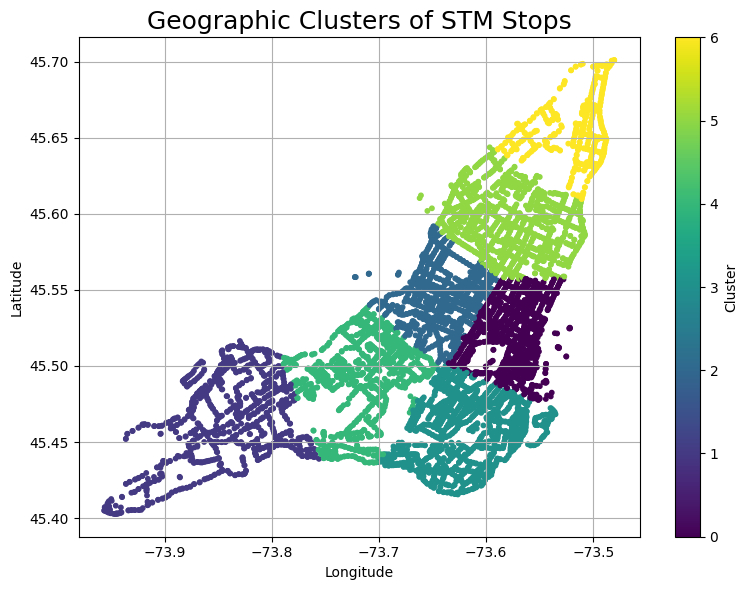

In [34]:
# Plot the clusters
plt.figure(figsize=(8, 6))
plt.scatter(x=stops_df['stop_lon'], y=stops_df['stop_lat'], c=stops_df['stop_location_group'], cmap='viridis', s=10)
plt.title('Geographic Clusters of STM Stops', fontsize=18)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.tight_layout()
plt.savefig('../images/stop_clusters.png', bbox_inches='tight')
plt.show()

In [35]:
# Merge clusters to dataframe
stops_df = stops_df.drop(['stop_name', 'stop_lat', 'stop_lon'], axis=1)
df = pd.merge(df, stops_df, how='inner', on='stop_id')

In [36]:
df.columns

Index(['trip_id', 'exp_trip_duration', 'route_id', 'stop_id', 'stop_name',
       'stop_lat', 'stop_lon', 'stop_distance', 'stop_sequence',
       'wheelchair_boarding', 'delay', 'delay_class', 'exp_delay_prev_stop',
       'temperature', 'relative_humidity', 'dew_point', 'precipitation',
       'pressure', 'cloud_cover', 'windspeed', 'wind_direction', 'wind_gusts',
       'hist_avg_delay', 'time_of_day_evening', 'time_of_day_morning',
       'time_of_day_night', 'is_peak_hour', 'route_type_HighFrequency',
       'route_type_Night', 'sch_rel_Scheduled', 'trip_phase_second_half',
       'route_direction_North', 'route_direction_South',
       'route_direction_West', 'stop_location_group'],
      dtype='object')

### Drop redundant/unnecessary columns


**Columns to drop**

`trip_id`: Identifies a vehicle on a specific day and might cause data leakage.<br>
`route_id`: The route types have been encoded.<br>
`stop_id`, `stop_name`, `stop_lat`, `stop_lon`: The stops are now clustered with K-Means.<br>
`stop_sequence`: The trip phases has been encoded.<br>

In [37]:
df = df.drop([
	'trip_id',
	'route_id',
	'stop_id',
	'stop_name',
	'stop_lat',
	'stop_lon',
	'stop_sequence'
  ], axis=1)

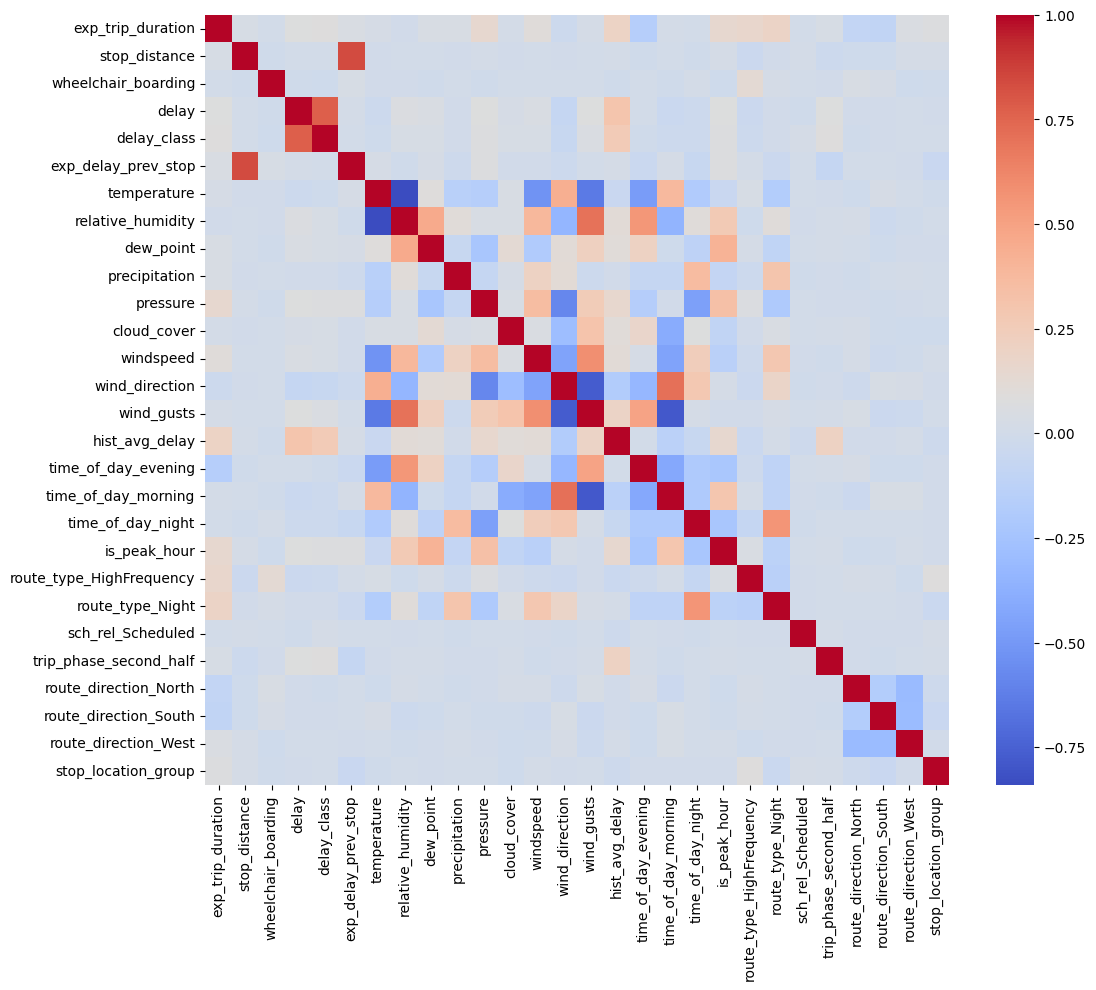

In [38]:
# Look for correlated features
corr_matrix = df.corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.show()

In [39]:
# Drop highly correlated and constant features 
df = df.drop(['exp_delay_prev_stop', 'relative_humidity', 'wind_gusts'], axis=1)

## Export Data

In [40]:
df.isna().sum()

exp_trip_duration           0
stop_distance               0
wheelchair_boarding         0
delay                       0
delay_class                 0
temperature                 0
dew_point                   0
precipitation               0
pressure                    0
cloud_cover                 0
windspeed                   0
wind_direction              0
hist_avg_delay              0
time_of_day_evening         0
time_of_day_morning         0
time_of_day_night           0
is_peak_hour                0
route_type_HighFrequency    0
route_type_Night            0
sch_rel_Scheduled           0
trip_phase_second_half      0
route_direction_North       0
route_direction_South       0
route_direction_West        0
stop_location_group         0
dtype: int64

In [41]:
# Assert all columns are numeric
assert len(df.columns) == len(df.select_dtypes([np.number]).columns)

In [42]:
# Exports coordinates scaler
with open('../models/scaler_coords.pkl', 'wb') as handle:
	pickle.dump(scaler_coords, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [43]:
# Export dataframe
df.to_parquet('../data/preprocessed.parquet', index=False)

## End